In [23]:
import numpy as np
import math
from fsap.sepr.section_property import SectionProperty as sp
from aashto.lrfd_8 import ch_5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
def calc_beta1(fc):
    return 0.85-0.05*(fc-4000)/1000

def calc_ecl_non_ps(fy, Es):
    if fy <= 60000.:
        ecl = min(fy/Es, 0.002)
    elif fy > 60000. and fy <= 100000.:
        ecl = 0.002 + (0.004-0.002) * (fy - 60000.)/(100000. - 60000.)
        
    return ecl

def calc_etl_non_ps(fy):
    if fy <=75000.:
        etl = 0.005
    elif fy > 75000. and fy <=100000.:
        etl = 0.005 + (0.008-0.005) * (fy - 75000.)/(100000. - 75000.)
        
    return etl

def calc_phi_non_ps(es, ecl, etl):
    if es <= ecl: #compression-controlled w/ spirals or ties
        phi = 0.75
    elif es > ecl and es <= etl: #transition
        phi = 0.75 + (0.9-0.75) * (es - ecl)/(etl - ecl)
    elif es > etl: #tension-controlled
        phi = 0.9
        
    return phi

def apply_aashto_capacity_reduction(es,fy,Es,p,m):
    ecl = calc_ecl_non_ps(fy, Es)
    etl = calc_etl_non_ps(fy)
    phi = calc_phi_non_ps(es, ecl, etl)
    
    return phi*p, phi*m




def calc_zeta(con_reinf):
    if con_reinf == "Spiral":
        zeta = 0.85 
    elif con_reinf == "Tied":
        zeta = 0.80
        
    return zeta
    
def calc_kc(fc):
    if fc < 10000:
        kc = 0.85
    elif fc >= 10000:
        kc = min(0.75, 0.85 - 0.02*(10000-fc))

    return kc

def calc_aashto_axial(kc, fc, Ag, Ast, fy, zeta):
    #Pn_AASHTO = zeta*(kc(fc)*fc*(Ag-Ast-Aps)+fy*Ast-Aps*(fpe-Ep*ecu))
    Pn_AASHTO = zeta*(kc*fc*(Ag-Ast)+fy*Ast)
    
    return Pn_AASHTO




def apply_aashto_axial_limit(pn, fc, Ag, Ast, fy, con_reinf):
    kc = calc_kc(fc)
    zeta = calc_zeta(con_reinf)
    
    pn_aashto = calc_aashto_axial(kc, fc, Ag, Ast, fy, zeta)
    
    return min(pn, pn_aashto)

In [25]:
class Fiber:
    def __init__(self, x, y, shape, dims):
        self.x = x
        self.y = y
        self.shape = shape
        self.dims = dims
        self.area = self.calc_area()
        
        self.strain = None #strain in the fiber
        self.stress = None #stress in the fiber
        self.force = None #force in fiber
    
    def calc_area(self):
        "Calculates area of fiber."
        if self.shape == "point":
            area = self.dims
        elif self.shape == "rect":
            area = self.dims[0]*self.dims[1]
        
        return area
    
    def calc_force(self):
        "Calculates force on the fiber."
        self.force = self.stress*self.area
    
    def calc_stress(self):
        pass
    
    def __repr__(self):
        text = (f' \n x: {self.x} \n y: {self.y} \n shape: {self.shape} \n dims: {self.dims} \n' +
                f' area: {self.area} \n strain: {self.strain} \n stress: {self.stress} \n force: {self.force}')
        return text
        
        
class ConcFiberT1(Fiber):
    """Concrete Fiber Type 1 - Elastic stress-strain profile"""
    
    def __init__(self, x, y, shape, dims, *args):
        Fiber.__init__(self, x, y, shape, dims)
        
        self.fcp = 0.85*args[0]
        self.Ec = args[1]

    def calc_stress(self):
        "Concrete stress-strain profile."
        if self.strain < 0.0:
            self.stress = 0.0 #no tensile strength of concrete
        elif self.strain <= self.fcp/self.Ec and self.strain > 0.0:
            self.stress = self.Ec*self.strain
        elif self.strain > self.fcp/self.Ec and self.strain <= 0.003:
            self.stress = self.fcp
        elif self.strain > 0.003:
            self.stress = 0.0 #useable concrete strain; concrete crushes
    
    def __repr__(self):
        text = super().__repr__() + f' \n Ec: {Ec}'
        return text

class SteelFiberT1(Fiber):
    """Steel Fiber Type 1 - Elasto-plastic stress-strain profile""" 
    
    def __init__(self, x, y, shape, dims, *args):
        Fiber.__init__(self, x, y, shape, dims)
        
        self.fy = args[0]
        self.Es = args[1]
        self.Ec = args[2] #for transforming the steel area
    
    def calc_stress(self):
        "Steel elasto-plastic stress-strain profile"
        if self.strain < self.fy/self.Es and self.strain > -self.fy/self.Es:
            self.stress = self.Es*self.strain
        else:
            self.stress = np.sign(self.strain)*self.fy
            
    def __repr__(self):
        text = super().__repr__() + f' \n fy: {self.fy} \n Es: {self.Es} \n Ec: {self.Ec}'
        return text
        
    
class Rebar:
    
    area_dict = {3:0.11, 4:0.20, 5:0.31, 6:0.44, 7:0.60, 8:0.79, 9:1.00, 10:1.27, 11:1.56, 14:2.25, 18:4.00}
    d_nom_dict = {3:0.375, 4:0.500, 5:0.625, 6:0.750, 7:0.875, 8:1.00, 9:1.128, 10:1.270, 11:1.41, 14:1.693, 18:2.257}
    
    def __init__(self, bar_size, fy, d=None, A=None):
        self.size = bar_size
        self.fy = fy
        self.d_nom = Rebar.d_nom_dict[bar_size]
        self.area = Rebar.area_dict[bar_size]
        
    def __repr__(self):
        text = (f' size: {self.size} \n fy: {self.fy} \n nominal diameter: {self.d_nom}' +
                f' \n area: {self.area}')
        return text
        




def calc_centroid(cfbs):
    sum_ax = 0.0
    sum_ay = 0.0
    sum_a = 0.0

    for cfb in cfbs:
        sum_ax = sum_ax + cfb.x*cfb.area
        sum_ay = sum_ay + cfb.y*cfb.area
        sum_a = sum_a + cfb.area

    xc = sum_ax / sum_a
    yc = sum_ay / sum_a
    
    return xc, yc

def centroid_translation(cfbs, sfbs):
    xc, yc = calc_centroid(cfbs)

    for cfb in cfbs:
        cfb.x = cfb.x - xc
        cfb.y = cfb.y - yc

    for sfb in sfbs:
        sfb.x = sfb.x - xc
        sfb.y = sfb.y - yc

def coord_rotation(x,y,theta):
    "Calculates the new x,y coordinates for the axes rotated theta degrees ccw."
    rot_mat = np.array([(math.cos(theta), -1*math.sin(theta)), (math.sin(theta), math.cos(theta))])
    xy = np.array([[x],[y]])
    rot_xy = np.matmul(rot_mat, xy)
    
    return rot_xy[0][0], rot_xy[1][0]

def lim_x(fbs):
    "Calculates the maximum and minimum x-coordinate of all the fibers."
    max_x = 0.0
    min_x = 0.0
    for fb in fbs:
        if fb.x > max_x:
            max_x = fb.x
        if fb.x < min_x:
            min_x = fb.x
    
    return max_x, min_x

def calc_pm(num_steps, max_x, min_x, cfbs, sfbs):
    """Calculates axial-moment interaction diagram.
    
    Negative strain is tensile
    
    """
    
    c_step = (max_x - min_x)/num_steps
    c = 0.0
    e_cu = 0.003 # how to handle this? part of concrete fiber class, parameter to pass to this function
    
    pm = []

    for step in range(num_steps):
        c += c_step
        
        pt = 0.0
        mt = 0.0
        cp = 0.0
        cm = 0.0
        sp = 0.0
        sm = 0.0
        scp = 0.0
        scm = 0.0
        
        #calc strain, stress, and force on fibers
        for cfb in cfbs:
            cfb.strain = e_cu/c * cfb.x - e_cu/c * max_x + e_cu
            cfb.calc_stress()
            cfb.calc_force()
        for sfb in sfbs:
            sfb.strain = e_cu/c * sfb.x - e_cu/c * max_x + e_cu
            sfb.calc_stress()
            sfb.calc_force()
            
        #calc total axial and moment capacity on section
        for cfb in cfbs:
            cp = cp + cfb.force
            cm = cm + cfb.force*cfb.x
        for sfb in sfbs:
            sp = sp + sfb.force
            sm = sm + sfb.force*sfb.x
            n = round(sfb.Es / sfb.Ec,1) #move this somewhere else
            scp = scp + sfb.force/n
            scm = scm + sfb.force*sfb.x/n

        pt = cp + sp - scp
        mt = cm + sm - scm

        pm.append((mt, pt))
        
    tension_capacity = 0.0
    for sfb in sfbs:
        tension_capacity = tension_capacity - sfb.fy*sfb.area
        
    pm.append((0.0, tension_capacity))
        
    return pm

#add graphing function for location of rebar and concrete fibers


In [26]:
fcp = 3.0
fy = 60.0
Ec = ch_5.eq5424d1(fcp)[0]
Es = 29000.

b = 30.
h = 30.
num_db = 30
num_dh = 30
db = b/num_db
dh = h/num_dh

# class SectionMesh:
# def rect_section_mesh():
cfbs = []

x = 0.
y = 0.
for bstep in range(num_db):
    if bstep == 0:
        x = db/2
    else:
        x = x + db
    for hstep in range(num_dh):
        if hstep == 0:
            y = dh/2
        else:
            y = y + dh
        nf = ConcFiberT1(x,y,"rect", (db,dh), fcp, Ec)
        cfbs.append(nf)
    y = 0.0
    
# def rebar_layout():
# class RebarLayout:
n9bar = Rebar(9, 60)

rb_locs = [(3.064, 3.064), (15.0, 3.064), (26.936, 3.064), (3.064, 15.0), (26.936, 15.0),
              (3.064, 26.936), (15, 26.936), (26.936, 26.936)]
sfbs = []

for loc in rb_locs:
    nf = SteelFiberT1(loc[0], loc[1], "point", n9bar.area, fy, Es, Ec)
    sfbs.append(nf)

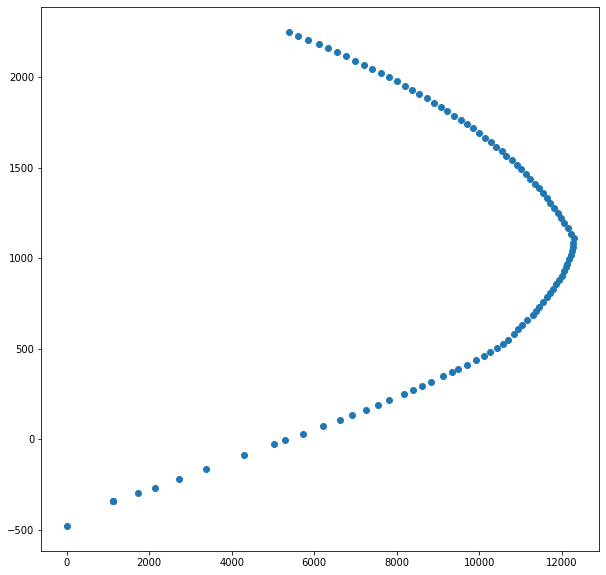

In [27]:
xc, yc = calc_centroid(cfbs)
centroid_translation(cfbs, sfbs)

theta = 0.*math.pi/180.
for cfb in cfbs:
    cfb.x, cfb.y = coord_rotation(cfb.x,cfb.y,theta)

for sfb in sfbs:
    sfb.x, sfb.y = coord_rotation(sfb.x, cfb.y, theta)

max_x, min_x = lim_x(cfbs)
pm = calc_pm(100, max_x, min_x, cfbs, sfbs)




plt.figure(figsize=(10,10))
plt.scatter(*zip(*pm))
plt.show()